<a href="https://colab.research.google.com/github/nourhanhamdyebrahim123/LULC_change_Alexandria/blob/main/LULC_classification_2050.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install patchify segmentation_models keras_unet_collection imagecodecs imagecodecs-lite scipy==1.11.4

In [ ]:
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Enable memory growth (don't pre-allocate all GPU memory)
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)

        # Optional: also set a hard memory limit on the first GPU (MiB)
        # tf.config.set_virtual_device_configuration(
        #     gpus[0],
        #     [tf.config.VirtualDeviceConfiguration(memory_limit=14000)])  # e.g. 14GB
    except Exception as e:
        print("Could not set GPU configs:", e)

In [ ]:
import os
import numpy as np
import scipy.signal
from tqdm import tqdm
from keras.models import load_model
import gc

import cv2

from matplotlib import pyplot as plt
from patchify import patchify
from PIL import Image
#import segmentation_models as sm # Commented out due to version conflict
from tensorflow.keras.metrics import MeanIoU

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow.keras.utils import to_categorical

scaler = MinMaxScaler()


import glob
import sys
from datetime import datetime
from tensorflow import keras
import tifffile as tif
from keras_unet_collection import models, losses
from sklearn.metrics import f1_score, jaccard_score

In [ ]:
# gpus = tf.config.list_physical_devices('GPU')
# if gpus:
#     try:
#         # Enable memory growth (don't pre-allocate all GPU memory)
#         for gpu in gpus:
#             tf.config.experimental.set_memory_growth(gpu, True)

#         # Optional: also set a hard memory limit on the first GPU (MiB)
#         # tf.config.set_virtual_device_configuration(
#         #     gpus[0],
#         #     [tf.config.VirtualDeviceConfiguration(memory_limit=14000)])  # e.g. 14GB
#     except Exception as e:
#         print("Could not set GPU configs:", e)

In [ ]:
#link to google drive
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#load the model
model_path = '/content/drive/My Drive/LULC_classification/FPN_50_epochs.hdf5'
model = load_model(model_path, compile=False) # Ensure this line is present and executed

In [ ]:
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"

In [ ]:
os.environ["CUDA_VISIBLE_DEVICES"]="0"
tf_device='/gpu:0'

for infile in sorted(glob.glob('*.tif')):
    print ("Current File Being Processed is: " + infile)


In [ ]:
if __name__ == '__main__':
    import matplotlib.pyplot as plt
    PLOT_PROGRESS = True
    # See end of file for the rest of the __main__.
else:
    PLOT_PROGRESS = False


def _spline_window(window_size, power=2):
    """
    Squared spline (power=2) window function:
    https://www.wolframalpha.com/input/?i=y%3Dx**2,+y%3D-(x-2)**2+%2B2,+y%3D(x-4)**2,+from+y+%3D+0+to+2
    """
    intersection = int(window_size/4)
    wind_outer = (abs(2*(scipy.signal.triang(window_size))) ** power)/2
    wind_outer[intersection:-intersection] = 0

    wind_inner = 1 - (abs(2*(scipy.signal.triang(window_size) - 1)) ** power)/2
    wind_inner[:intersection] = 0
    wind_inner[-intersection:] = 0

    wind = wind_inner + wind_outer
    wind = wind / np.average(wind)
    return wind


cached_2d_windows = dict()
def _window_2D(window_size, power=2):
    """
    Make a 1D window function, then infer and return a 2D window function.
    Done with an augmentation, and self multiplication with its transpose.
    Could be generalized to more dimensions.
    """
    # Memoization
    global cached_2d_windows
    key = "{}_{}".format(window_size, power)
    if key in cached_2d_windows:
        wind = cached_2d_windows[key]
    else:
        wind = _spline_window(window_size, power)
        wind = np.expand_dims(np.expand_dims(wind, 1), 1)      #SREENI: Changed from 3, 3, to 1, 1
        wind = wind * wind.transpose(1, 0, 2)
        if PLOT_PROGRESS:
            # For demo purpose, let's look once at the window:
            plt.imshow(wind[:, :, 0], cmap="viridis")
            plt.title("2D Windowing Function for a Smooth Blending of "
                      "Overlapping Patches")
            plt.show()
        cached_2d_windows[key] = wind
    return wind


def _pad_img(img, window_size, subdivisions):
    """
    Add borders to img for a "valid" border pattern according to "window_size" and
    "subdivisions".
    Image is an np array of shape (x, y, nb_channels).
    """
    aug = int(round(window_size * (1 - 1.0/subdivisions)))
    more_borders = ((aug, aug), (aug, aug), (0, 0))
    ret = np.pad(img, pad_width=more_borders, mode='reflect')
    # gc.collect()

    if PLOT_PROGRESS:
        # For demo purpose, let's look once at the window:
        plt.imshow(ret)
        plt.title("Padded Image for Using Tiled Prediction Patches\n"
                  "(notice the reflection effect on the padded borders)")
        plt.show()
    return ret


def _unpad_img(padded_img, window_size, subdivisions):
    """
    Undo what's done in the `_pad_img` function.
    Image is an np array of shape (x, y, nb_channels).
    """
    aug = int(round(window_size * (1 - 1.0/subdivisions)))
    ret = padded_img[
        aug:-aug,
        aug:-aug,
        :
    ]
    # gc.collect()
    return ret


def _rotate_mirror_do(im):
    """
    Duplicate an np array (image) of shape (x, y, nb_channels) 8 times, in order
    to have all the possible rotations and mirrors of that image that fits the
    possible 90 degrees rotations.
    It is the D_4 (D4) Dihedral group:
    https://en.wikipedia.org/wiki/Dihedral_group
    """
    mirrs = []
    mirrs.append(np.array(im))
    mirrs.append(np.rot90(np.array(im), axes=(0, 1), k=1))
    mirrs.append(np.rot90(np.array(im), axes=(0, 1), k=2))
    mirrs.append(np.rot90(np.array(im), axes=(0, 1), k=3))
    im = np.array(im)[:, ::-1]
    mirrs.append(np.array(im))
    mirrs.append(np.rot90(np.array(im), axes=(0, 1), k=3))
    mirrs.append(np.rot90(np.array(im), axes=(0, 1), k=2))
    mirrs.append(np.rot90(np.array(im), axes=(0, 1), k=1))
    return mirrs


def _rotate_mirror_undo(im_mirrs):
    """
    merges a list of 8 np arrays (images) of shape (x, y, nb_channels) generated
    from the `_rotate_mirror_do` function. Each images might have changed and
    merging them implies to rotated them back in order and average things out.
    It is the D_4 (D4) Dihedral group:
    https://en.wikipedia.org/wiki/Dihedral_group
    """
    origs = []
    origs.append(np.array(im_mirrs[0]))
    origs.append(np.rot90(np.array(im_mirrs[1]), axes=(0, 1), k=3))
    origs.append(np.rot90(np.array(im_mirrs[2]), axes=(0, 1), k=2))
    origs.append(np.rot90(np.array(im_mirrs[3]), axes=(0, 1), k=1))
    origs.append(np.array(im_mirrs[4])[:, ::-1])
    origs.append(np.rot90(np.array(im_mirrs[5]), axes=(0, 1), k=3)[:, ::-1])
    origs.append(np.rot90(np.array(im_mirrs[6]), axes=(0, 1), k=2)[:, ::-1])
    origs.append(np.rot90(np.array(im_mirrs[7]), axes=(0, 1), k=1)[:, ::-1])
    return np.mean(origs, axis=0)


def _windowed_subdivs(padded_img, window_size, subdivisions, nb_classes, pred_func):
    """
    Create tiled overlapping patches.
    Returns:
        5D numpy array of shape = (
            nb_patches_along_X,
            nb_patches_along_Y,
            patches_resolution_along_X,
            patches_resolution_along_Y,
            nb_output_channels
        )
    Note:
        patches_resolution_along_X == patches_resolution_along_Y == window_size
    """
    WINDOW_SPLINE_2D = _window_2D(window_size=window_size, power=2)

    step = int(window_size/subdivisions)
    padx_len = padded_img.shape[0]
    pady_len = padded_img.shape[1]
    subdivs = []

    for i in range(0, padx_len-window_size+1, step):
        subdivs.append([])
        for j in range(0, pady_len-window_size+1, step):                #SREENI: Changed padx to pady (Bug in original code)
            patch = padded_img[i:i+window_size, j:j+window_size, :]
            subdivs[-1].append(patch)

    # Here, `gc.collect()` clears RAM between operations.
    # It should run faster if they are removed, if enough memory is available.
    gc.collect()
    subdivs = np.array(subdivs)
    gc.collect()
    a, b, c, d, e = subdivs.shape
    subdivs = subdivs.reshape(a * b, c, d, e)
    gc.collect()

    subdivs = pred_func(subdivs)
    gc.collect()
    subdivs = np.array([patch * WINDOW_SPLINE_2D for patch in subdivs])
    gc.collect()

    # Such 5D array:
    subdivs = subdivs.reshape(a, b, c, d, nb_classes)
    gc.collect()

    return subdivs


def _recreate_from_subdivs(subdivs, window_size, subdivisions, padded_out_shape):
    """
    Merge tiled overlapping patches smoothly.
    """
    step = int(window_size/subdivisions)
    padx_len = padded_out_shape[0]
    pady_len = padded_out_shape[1]

    y = np.zeros(padded_out_shape)

    a = 0
    for i in range(0, padx_len-window_size+1, step):
        b = 0
        for j in range(0, pady_len-window_size+1, step):                #SREENI: Changed padx to pady (Bug in original code)
            windowed_patch = subdivs[a, b]
            y[i:i+window_size, j:j+window_size] = y[i:i+window_size, j:j+window_size] + windowed_patch
            b += 1
        a += 1
    return y / (subdivisions ** 2)


def predict_img_with_smooth_windowing(input_img, window_size, subdivisions, nb_classes, pred_func):
    """
    Apply the `pred_func` function to square patches of the image, and overlap
    the predictions to merge them smoothly.
    See 6th, 7th and 8th idea here:
    http://blog.kaggle.com/2017/05/09/dstl-satellite-imagery-competition-3rd-place-winners-interview-vladimir-sergey/
    """
    pad = _pad_img(input_img, window_size, subdivisions)
    pads = _rotate_mirror_do(pad)

    # Note that the implementation could be more memory-efficient by merging
    # the behavior of `_windowed_subdivs` and `_recreate_from_subdivs` into
    # one loop doing in-place assignments to the new image matrix, rather than
    # using a temporary 5D array.

    # It would also be possible to allow different (and impure) window functions
    # that might not tile well. Adding their weighting to another matrix could
    # be done to later normalize the predictions correctly by dividing the whole
    # reconstructed thing by this matrix of weightings - to normalize things
    # back from an impure windowing function that would have badly weighted
    # windows.

    # For example, since the U-net of Kaggle's DSTL satellite imagery feature
    # prediction challenge's 3rd place winners use a different window size for
    # the input and output of the neural net's patches predictions, it would be
    # possible to fake a full-size window which would in fact just have a narrow
    # non-zero dommain. This may require to augment the `subdivisions` argument
    # to 4 rather than 2.

    res = []
    for pad in tqdm(pads):
        # For every rotation:
        sd = _windowed_subdivs(pad, window_size, subdivisions, nb_classes, pred_func)
        one_padded_result = _recreate_from_subdivs(
            sd, window_size, subdivisions,
            padded_out_shape=list(pad.shape[:-1])+[nb_classes])

        res.append(one_padded_result)

    # Merge after rotations:
    padded_results = _rotate_mirror_undo(res)

    prd = _unpad_img(padded_results, window_size, subdivisions)

    prd = prd[:input_img.shape[0], :input_img.shape[1], :]

    if PLOT_PROGRESS:
        plt.imshow(prd)
        plt.title("Smoothly Merged Patches that were Tiled Tighter")
        plt.show()
    return prd

In [ ]:
# size of patches
patch_size = 256
n_classes = 4
subset_dataset = []
classified_dataset = []

scaler = MinMaxScaler()
results_list =[]

In [ ]:
# Path to your dataset folder in Drive
test_directory = "/content/drive/My Drive/LULC_classification/Alexandria"



In [ ]:
# List files
print(os.listdir(test_directory))

['images']


In [ ]:
def label_to_rgb(predicted_img):

    Cultivated = (0,255,0)
    Water = (0,0,255)
    Builtup = (255,0,0)
    Bareland = (255,255,0)


    segmented_img = np.empty((predicted_img.shape[0], predicted_img.shape[1], 3), dtype=np.uint8)
    segmented_img[(predicted_img == 0)] = Cultivated
    segmented_img[(predicted_img == 1)] = Water
    segmented_img[(predicted_img == 2)] = Builtup
    segmented_img[(predicted_img == 3)] = Bareland

    # segmented_img = segmented_img.astype(np.uint8) # Already specified dtype
    return (segmented_img)

In [ ]:
for path, subdirs, files in os.walk(test_directory):
    print("Hello")
    print(path)
    # dirname = path.split(os.path.sep)[-1]
    dirname = path.split(os.path.sep)[-1]
    print(dirname)
    if dirname == 'images':
        print("hello_00")
        subsets = os.listdir(path)
        for i, subset_name in enumerate(subsets):
            print("hello_01")
            if subset_name.endswith("tif"):
                print("hello_02")
                print(path+"/"+subset_name)
                subset = tif.imread(path+"/"+subset_name)
                #gror_red = subset[:,:,1]
                #redor_NIR = subset[:,:,2]
                #NIRor_therm = subset[:,:,3]
                #three_channel_img = cv2.merge((gror_red, redor_NIR, NIRor_therm))
                #input_img = scaler.fit_transform(three_channel_img.reshape(-1,three_channel_img.shape[-1])).reshape(three_channel_img.shape)
                input_img = scaler.fit_transform(subset.reshape(-1,subset.shape[-1])).reshape(subset.shape)
                subset_dataset.append(input_img)


print(len(subset_dataset))


Hello
/content/drive/My Drive/LULC_classification/Alexandria
Alexandria
Hello
/content/drive/My Drive/LULC_classification/Alexandria/images
images
hello_00
hello_01
hello_02
/content/drive/My Drive/LULC_classification/Alexandria/images/subset_2025_Alexandria.tif
hello_01
hello_02
/content/drive/My Drive/LULC_classification/Alexandria/images/subset_1995_Alexandria.tif
hello_01
hello_02
/content/drive/My Drive/LULC_classification/Alexandria/images/subset_2005_Alexandria.tif
hello_01
hello_02
/content/drive/My Drive/LULC_classification/Alexandria/images/subset_2015_Alexandria.tif
4


In [ ]:


# for path, subdirs, files in os.walk(test_directory):
#      print(path)
#      dirname = path.split(os.path.sep)[-1]
#      if dirname == 'masks':
#          masks = os.listdir(path)
#          for i, classified_name in enumerate(masks):
#              if classified_name.endswith("tif"):
#                  print(path+"/"+classified_name)
#                  classified = tif.imread(path+"/"+classified_name)
#                  classified_dataset.append(classified)


# print(len(classified_dataset))



/content/drive/My Drive/LULC_classification/Alexandria
/content/drive/My Drive/LULC_classification/Alexandria/images
0


k of ground 0


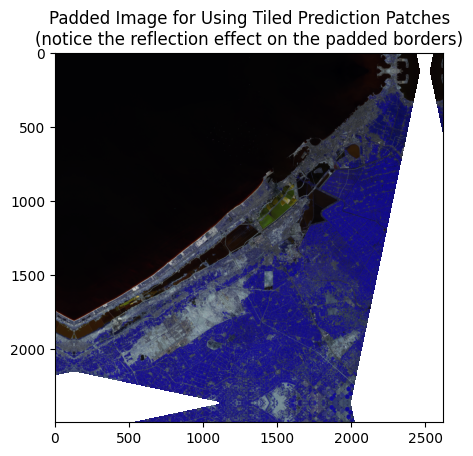

  0%|          | 0/8 [00:00<?, ?it/s]/tmp/ipython-input-1184571576.py:15: DeprecationWarning: Importing triang from 'scipy.signal' is deprecated and will raise an error in SciPy 1.13.0. Please use 'scipy.signal.windows.triang' or the convenience function 'scipy.signal.get_window' instead.
  wind_outer = (abs(2*(scipy.signal.triang(window_size))) ** power)/2
/tmp/ipython-input-1184571576.py:18: DeprecationWarning: Importing triang from 'scipy.signal' is deprecated and will raise an error in SciPy 1.13.0. Please use 'scipy.signal.windows.triang' or the convenience function 'scipy.signal.get_window' instead.
  wind_inner = 1 - (abs(2*(scipy.signal.triang(window_size) - 1)) ** power)/2


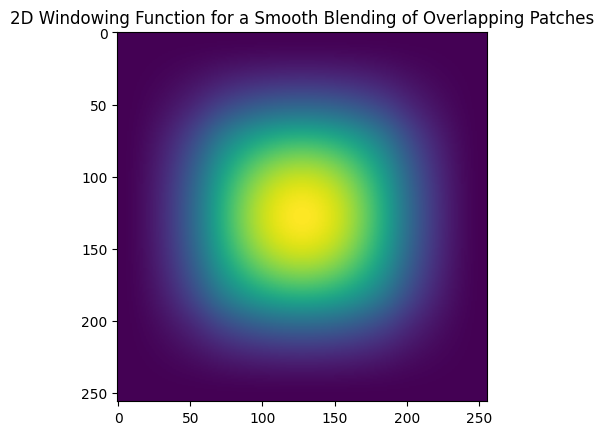

11/11 ━━━━━━━━━━━━━━━━━━━━ 70s 3s/step


 12%|█▎        | 1/8 [01:13<08:34, 73.50s/it]

11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 396ms/step


 25%|██▌       | 2/8 [01:22<03:31, 35.30s/it]

11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 397ms/step


 38%|███▊      | 3/8 [01:30<01:55, 23.12s/it]

11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 397ms/step


 50%|█████     | 4/8 [01:39<01:09, 17.28s/it]

11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 407ms/step


 62%|██████▎   | 5/8 [01:47<00:42, 14.08s/it]

11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 407ms/step


 75%|███████▌  | 6/8 [01:56<00:24, 12.39s/it]

11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 414ms/step


 88%|████████▊ | 7/8 [02:05<00:11, 11.13s/it]

11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 413ms/step


100%|██████████| 8/8 [02:13<00:00, 16.72s/it]


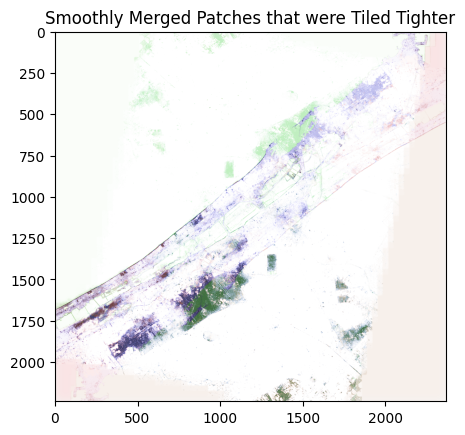

Execution time is:  0:02:20.139915


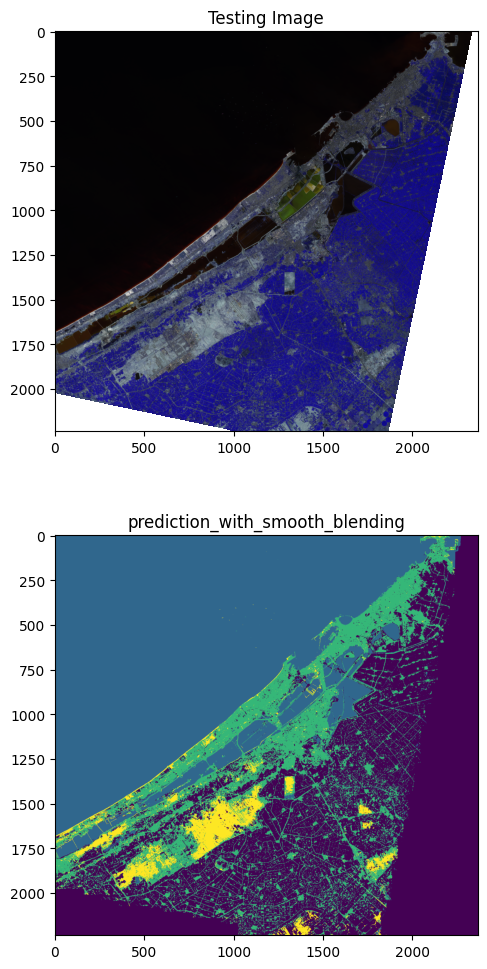

k of ground 1


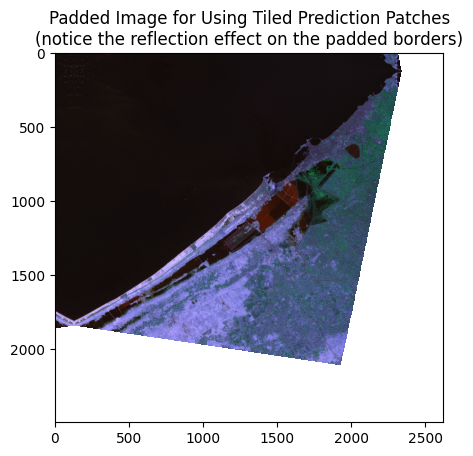

  0%|          | 0/8 [00:00<?, ?it/s]

11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 403ms/step


 12%|█▎        | 1/8 [00:08<00:57,  8.17s/it]

11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 413ms/step


 25%|██▌       | 2/8 [00:16<00:50,  8.45s/it]

11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 407ms/step


 38%|███▊      | 3/8 [00:25<00:43,  8.65s/it]

11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 396ms/step


 50%|█████     | 4/8 [00:33<00:33,  8.49s/it]

11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 403ms/step


 62%|██████▎   | 5/8 [00:41<00:24,  8.31s/it]

11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 399ms/step


 75%|███████▌  | 6/8 [00:50<00:16,  8.44s/it]

11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 408ms/step


 88%|████████▊ | 7/8 [00:59<00:08,  8.52s/it]

11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 407ms/step


100%|██████████| 8/8 [01:07<00:00,  8.45s/it]


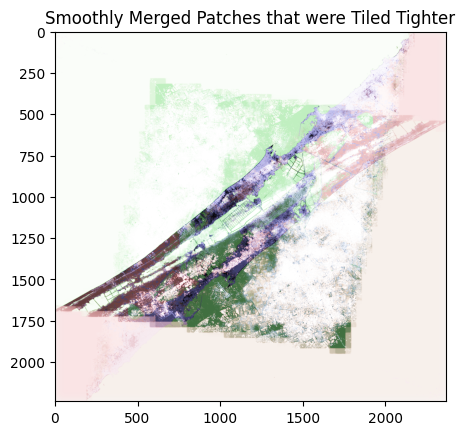

Execution time is:  0:01:13.258722


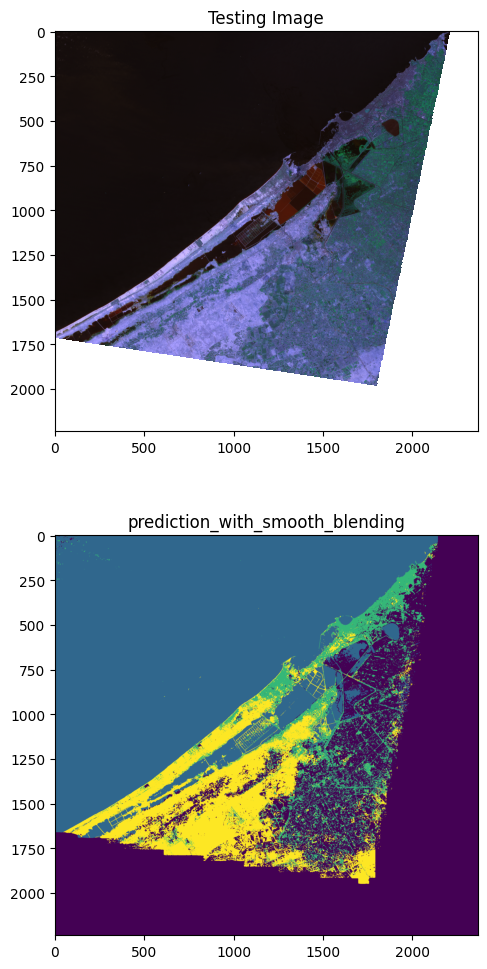

k of ground 2


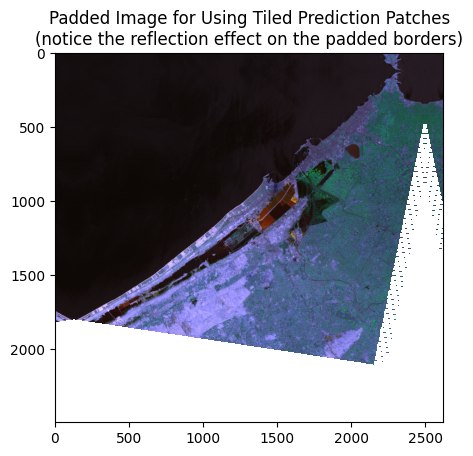

  0%|          | 0/8 [00:00<?, ?it/s]

11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 406ms/step


 12%|█▎        | 1/8 [00:08<00:58,  8.37s/it]

11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 412ms/step


 25%|██▌       | 2/8 [00:17<00:51,  8.58s/it]

11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 412ms/step


 38%|███▊      | 3/8 [00:25<00:42,  8.42s/it]

11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 410ms/step


 50%|█████     | 4/8 [00:34<00:34,  8.54s/it]

11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 411ms/step


 62%|██████▎   | 5/8 [00:42<00:25,  8.57s/it]

11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 409ms/step


 75%|███████▌  | 6/8 [00:51<00:17,  8.55s/it]

11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 409ms/step


 88%|████████▊ | 7/8 [00:59<00:08,  8.49s/it]

11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 406ms/step


100%|██████████| 8/8 [01:08<00:00,  8.56s/it]


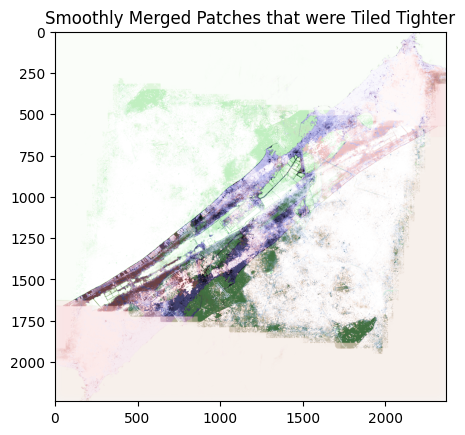

Execution time is:  0:01:13.514917


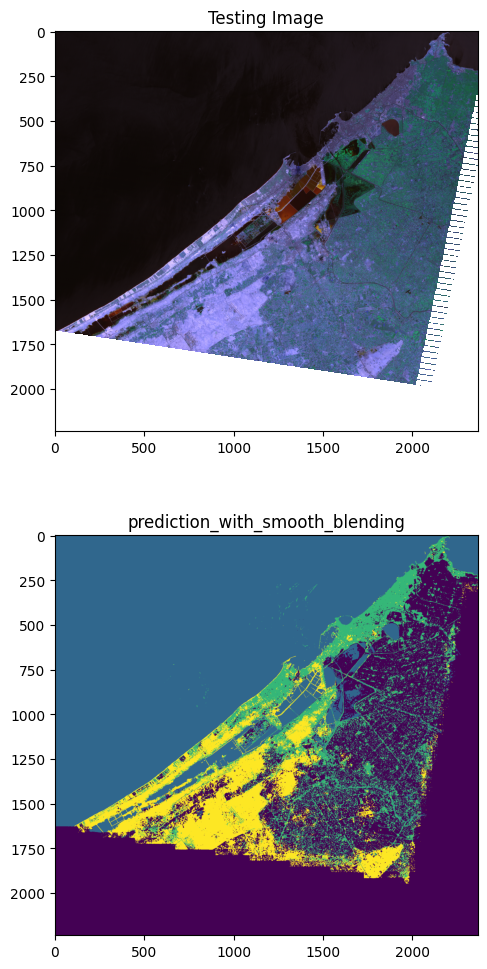

k of ground 3


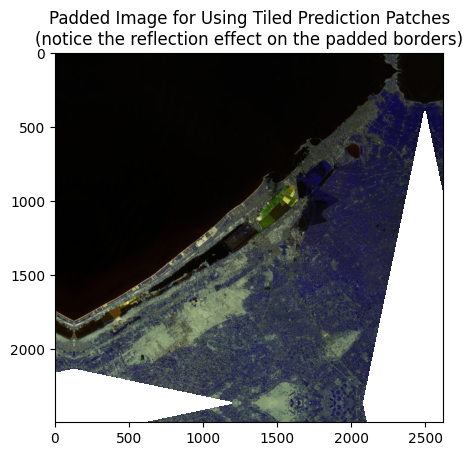

  0%|          | 0/8 [00:00<?, ?it/s]

11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 410ms/step


 12%|█▎        | 1/8 [00:08<00:57,  8.15s/it]

11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 409ms/step


 25%|██▌       | 2/8 [00:16<00:50,  8.36s/it]

11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 413ms/step


 38%|███▊      | 3/8 [00:25<00:42,  8.50s/it]

11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 417ms/step


 50%|█████     | 4/8 [00:33<00:34,  8.54s/it]

11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 416ms/step


 62%|██████▎   | 5/8 [00:42<00:25,  8.44s/it]

11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 417ms/step


 75%|███████▌  | 6/8 [00:51<00:17,  8.59s/it]

11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 422ms/step


 88%|████████▊ | 7/8 [00:59<00:08,  8.61s/it]

11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 409ms/step


100%|██████████| 8/8 [01:08<00:00,  8.51s/it]


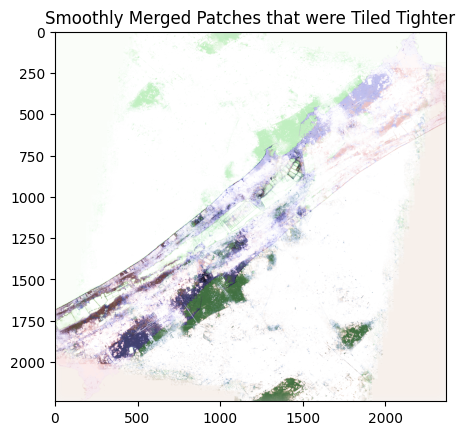

Execution time is:  0:01:13.866690


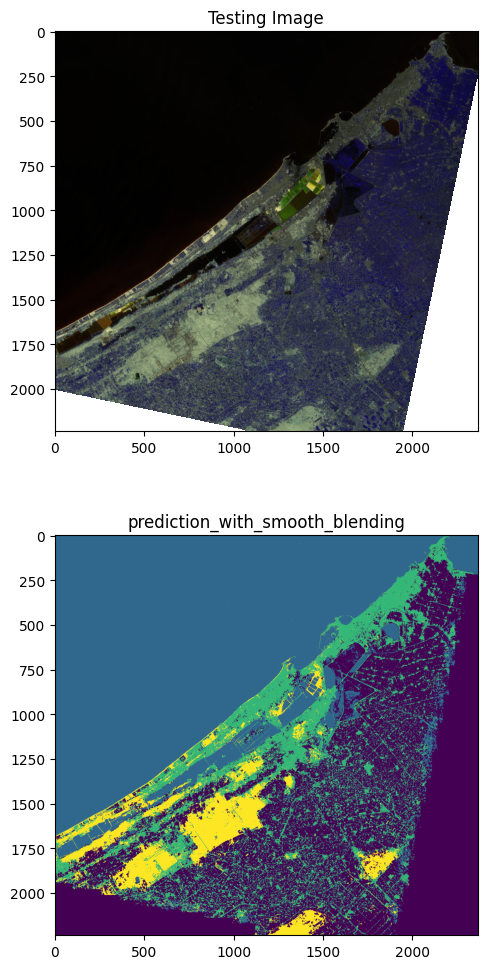

In [ ]:
for k in range(len(subset_dataset)):
    ground_truth = subset_dataset[k]
    print ("k of ground", k)
    # masked_img = classified_dataset[k]
    # print ("k of masked", k)
    start = datetime.now() # Define start here

   # predict using smooth blending
    predictions_smooth = predict_img_with_smooth_windowing(
                                       subset_dataset[k],
                                       window_size = patch_size,
                                       subdivisions=2,
                                       nb_classes=n_classes,
                                       pred_func=(
                                           lambda img_batch_subdiv: model.predict((img_batch_subdiv))
                                      )
                )

    final_prediction = np.argmax(predictions_smooth, axis=2)
    #masked_img_flat = masked_img.flatten()

    # ground_truth_flat = ground_truth.flatten()
    # final_prediction = final_prediction.flatten() # Remove flattening
    #f1_score_value = f1_score(masked_img_flat, predicted_img_flat, average="weighted")
    #jaccard_index = jaccard_score(masked_img_flat, predicted_img_flat, average="weighted")
    prediction_with_smooth_blending = label_to_rgb(final_prediction)
    #print("f1 score value is is: ", f1_score_value)
    #print("jaccard index value is is: ", jaccard_score)







    stop = datetime.now()
    #Execution time of the model
    Inference_time = stop-start
    print("Execution time is: ", Inference_time)




    #plot and save results

    plt.figure(figsize=(12,12))
    plt.subplot(221)
    plt.title('Testing Image')
    plt.imshow(ground_truth)


    # plt.subplot(222)
    # plt.title('Testing Label')
    # plt.imshow(masked_img)

    plt.subplot(223)
    plt.title('prediction_with_smooth_blending')
    plt.imshow(prediction_with_smooth_blending)

    plt.show()

    tif.imwrite('prediction_with_smooth_blending_label_'+str(k)+'.tif', prediction_with_smooth_blending)

In [ ]:
!pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 115.7 MB/s eta 0:00:00


Processing sample: 0


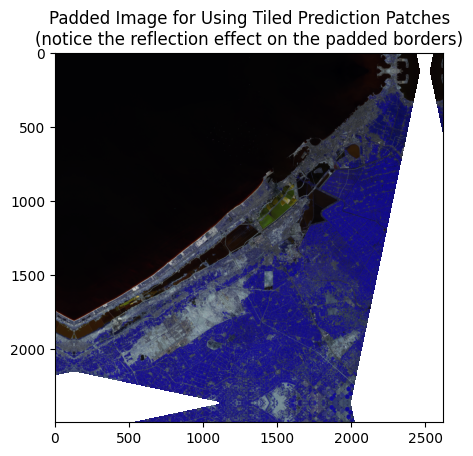

  0%|          | 0/8 [00:00<?, ?it/s]

11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 391ms/step


 12%|█▎        | 1/8 [00:07<00:55,  7.98s/it]

11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 395ms/step


 25%|██▌       | 2/8 [00:16<00:50,  8.35s/it]

11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 399ms/step


 38%|███▊      | 3/8 [00:25<00:42,  8.46s/it]

11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 399ms/step


 50%|█████     | 4/8 [00:33<00:33,  8.37s/it]

11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 411ms/step


 62%|██████▎   | 5/8 [00:41<00:25,  8.34s/it]

11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 408ms/step


 75%|███████▌  | 6/8 [00:50<00:17,  8.57s/it]

11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 408ms/step


 88%|████████▊ | 7/8 [00:58<00:08,  8.46s/it]

11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 414ms/step


100%|██████████| 8/8 [01:07<00:00,  8.42s/it]


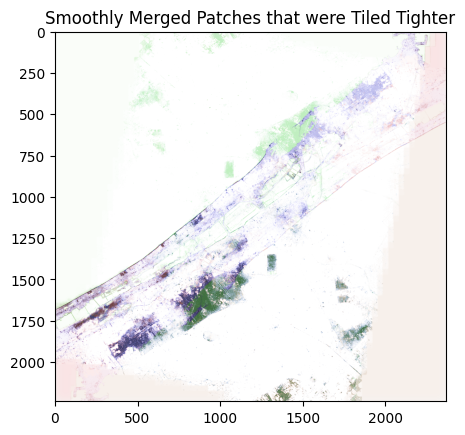

✅ Inference time: 0:01:12.252065


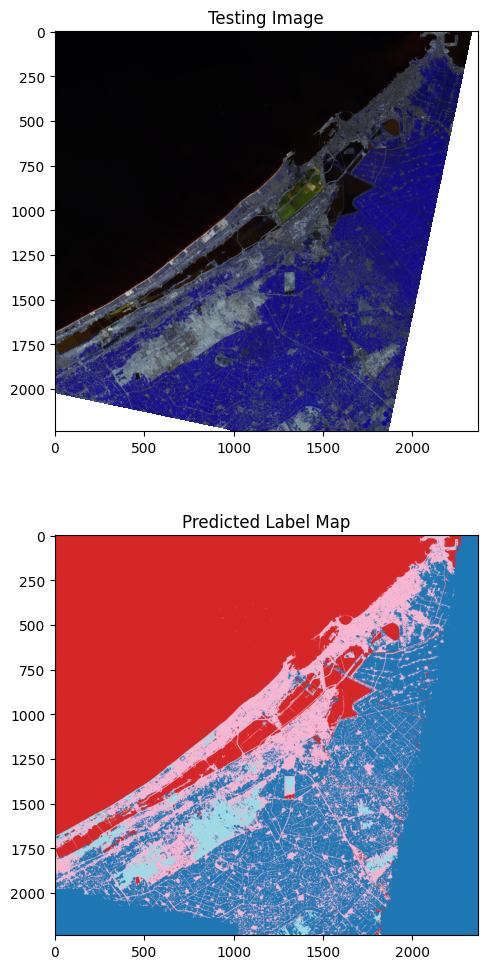

/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:366: NotGeoreferencedWarning: The given matrix is equal to Affine.identity or its flipped counterpart. GDAL may ignore this matrix and save no geotransform without raising an error. This behavior is somewhat driver-specific.
  dataset = writer(


🗺️ Saved: prediction_with_smooth_blending_label_00.tif
Processing sample: 1


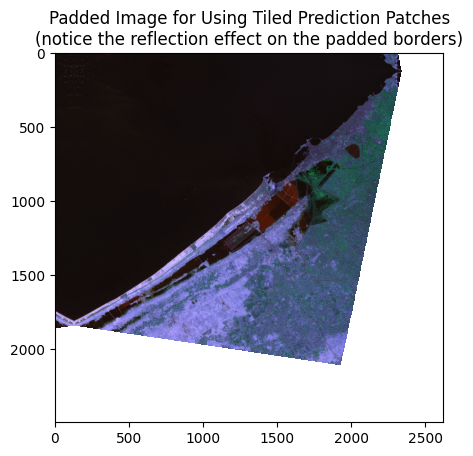

  0%|          | 0/8 [00:00<?, ?it/s]

11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 398ms/step


 12%|█▎        | 1/8 [00:08<00:58,  8.31s/it]

11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 404ms/step


 25%|██▌       | 2/8 [00:16<00:50,  8.41s/it]

11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 402ms/step


 38%|███▊      | 3/8 [00:24<00:41,  8.31s/it]

11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 400ms/step


 50%|█████     | 4/8 [00:33<00:33,  8.47s/it]

11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 401ms/step


 62%|██████▎   | 5/8 [00:42<00:25,  8.47s/it]

11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 401ms/step


 75%|███████▌  | 6/8 [00:50<00:16,  8.39s/it]

11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 405ms/step


 88%|████████▊ | 7/8 [00:59<00:08,  8.48s/it]

11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 400ms/step


100%|██████████| 8/8 [01:07<00:00,  8.49s/it]


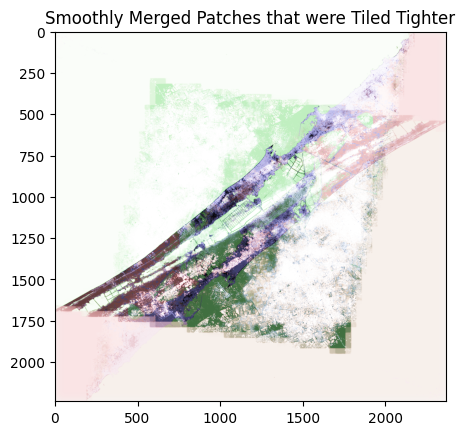

✅ Inference time: 0:01:12.939248


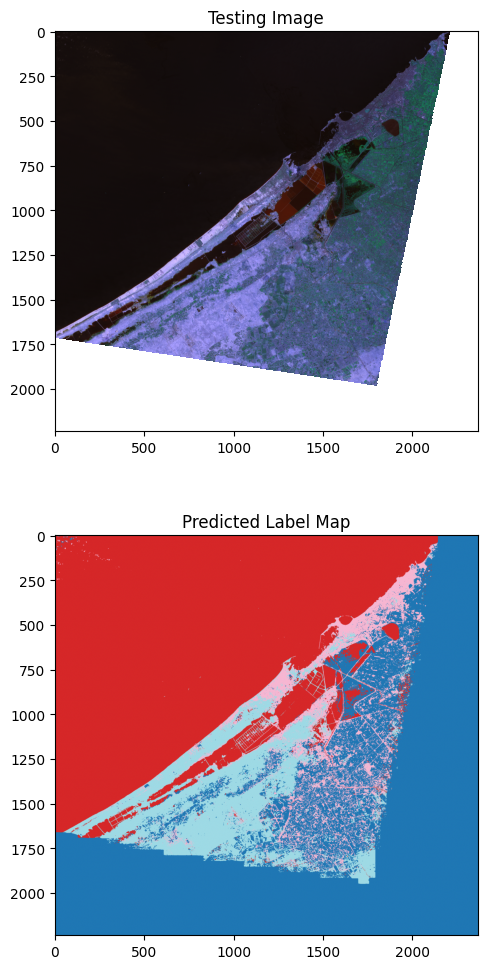

🗺️ Saved: prediction_with_smooth_blending_label_01.tif
Processing sample: 2


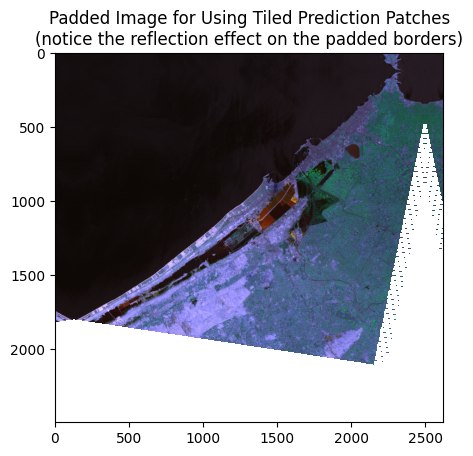

  0%|          | 0/8 [00:00<?, ?it/s]

11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 405ms/step


 12%|█▎        | 1/8 [00:08<00:56,  8.14s/it]

11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 401ms/step


 25%|██▌       | 2/8 [00:16<00:49,  8.31s/it]

11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 414ms/step


 38%|███▊      | 3/8 [00:25<00:42,  8.58s/it]

11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 410ms/step


 50%|█████     | 4/8 [00:34<00:34,  8.65s/it]

11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 401ms/step


 62%|██████▎   | 5/8 [00:42<00:25,  8.42s/it]

11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 403ms/step


 75%|███████▌  | 6/8 [00:50<00:17,  8.50s/it]

11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 409ms/step


 88%|████████▊ | 7/8 [00:59<00:08,  8.60s/it]

11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 402ms/step


100%|██████████| 8/8 [01:07<00:00,  8.50s/it]


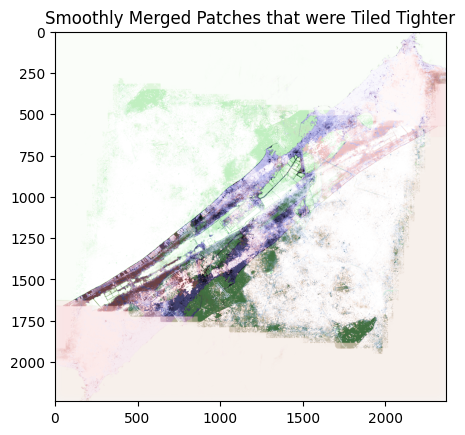

✅ Inference time: 0:01:13.625769


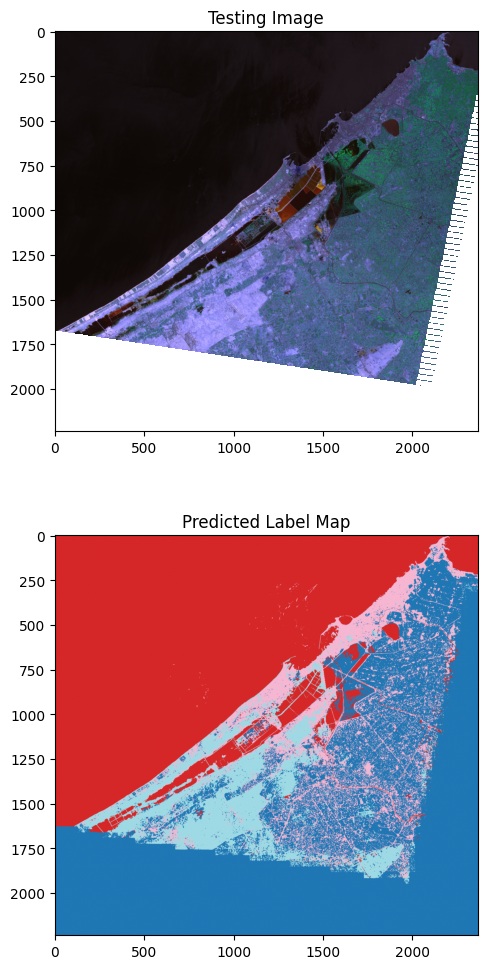

🗺️ Saved: prediction_with_smooth_blending_label_02.tif
Processing sample: 3


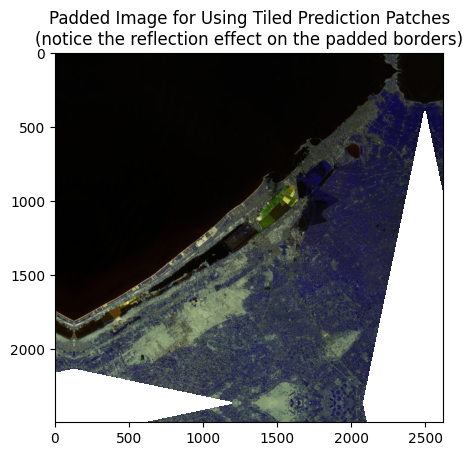

  0%|          | 0/8 [00:00<?, ?it/s]

11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 402ms/step


 12%|█▎        | 1/8 [00:08<00:59,  8.52s/it]

11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 406ms/step


 25%|██▌       | 2/8 [00:17<00:51,  8.58s/it]

11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 418ms/step


 38%|███▊      | 3/8 [00:25<00:42,  8.50s/it]

11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 412ms/step


 50%|█████     | 4/8 [00:34<00:34,  8.68s/it]

11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 413ms/step


 62%|██████▎   | 5/8 [00:42<00:25,  8.60s/it]

11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 420ms/step


 75%|███████▌  | 6/8 [00:51<00:17,  8.59s/it]

11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 413ms/step


 88%|████████▊ | 7/8 [01:00<00:08,  8.57s/it]

11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 409ms/step


100%|██████████| 8/8 [01:08<00:00,  8.62s/it]


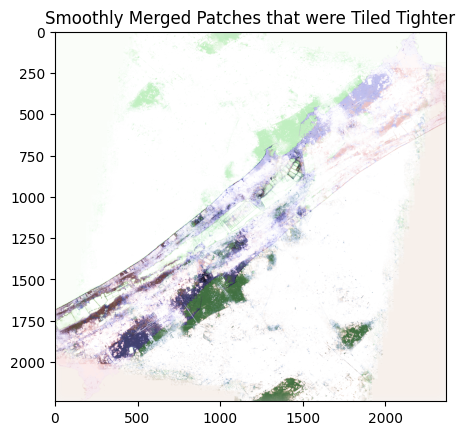

✅ Inference time: 0:01:14.123115


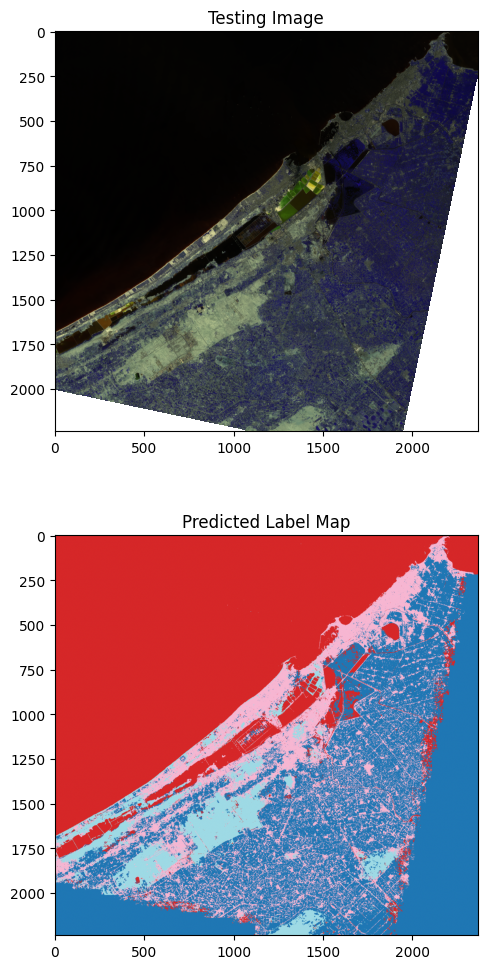

🗺️ Saved: prediction_with_smooth_blending_label_03.tif
🎉 All predictions saved successfully.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from rasterio.transform import from_origin
from datetime import datetime

# --- Prediction Loop ---
for k in range(len(subset_dataset)):
    ground_truth = subset_dataset[k]
    print("Processing sample:", k)

    start = datetime.now()

    # --- Predict using smooth blending ---
    predictions_smooth = predict_img_with_smooth_windowing(
        subset_dataset[k],
        window_size=patch_size,
        subdivisions=2,
        nb_classes=n_classes,
        pred_func=(lambda img_batch_subdiv: model.predict(img_batch_subdiv))
    )

    # Take the class with the highest probability per pixel
    final_prediction = np.argmax(predictions_smooth, axis=2)

    stop = datetime.now()
    print("✅ Inference time:", stop - start)

    # --- Visualization (optional) ---
    plt.figure(figsize=(12, 12))
    plt.subplot(221)
    plt.title('Testing Image')
    plt.imshow(ground_truth)

    plt.subplot(223)
    plt.title('Predicted Label Map')
    plt.imshow(final_prediction, cmap='tab20')
    plt.show()

    # --- Save prediction as a valid raster using rasterio ---
    output_path = f'prediction_with_smooth_blending_label_{k:02d}.tif'

    # Create a dummy transform (so ArcGIS recognizes it as a raster)
    transform = from_origin(0, 0, 1, 1)

    # Convert to uint8 (or uint16 depending on your number of classes)
    final_prediction = final_prediction.astype('uint8')

    with rasterio.open(
        output_path,
        'w',
        driver='GTiff',
        height=final_prediction.shape[0],
        width=final_prediction.shape[1],
        count=1,                  # Single band (class index)
        dtype=final_prediction.dtype,
        transform=transform,
        crs=None                  # No coordinate system
    ) as dst:
        dst.write(final_prediction, 1)

    print(f"🗺️ Saved: {output_path}")

print("🎉 All predictions saved successfully.")
